Notebook to study LJ pT and bound state mass resolution

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
#plotting
import matplotlib.pyplot as plt
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from analysis.tools import ffschema, sidm_processor
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)

<module 'analysis.tools.sidm_processor' from '/home/cms-jovyan/SIDM/analysis/studies/../../analysis/tools/sidm_processor.py'>

Start by looking at default 2mu2e sample with 2mu2e selection and matched dark photons.

In [2]:
fileset = {
    "2Mu2E_100GeV_1p2GeV_9p6mm": [
        "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-9p6_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161703/0000/ffNtuple_1.root",
    ],
    # can't open new files at the moment; waiting on intervention from coffea-casa folks
    #"2Mu2E_100GeV_1p2GeV_0p096mm": [
    #    "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-0p096_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_155855/0000/ffNtuple_1.root",
    #],
}

In [3]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
)

p = sidm_processor.SidmProcessor(
    [
        "2mu2e_matchedLj",
    ],
    ["base_plus_gen"]
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
hists = output["out"]["2Mu2E_100GeV_1p2GeV_9p6mm"]["hists"]

Output()

Output()

Take a look at ratio of LJ pT to dark photon pT

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fed2cafff70>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

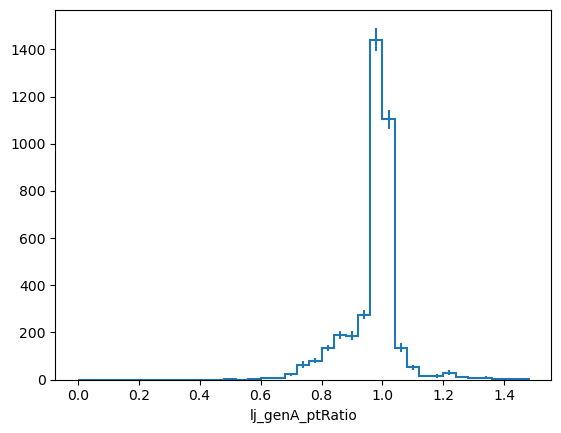

In [4]:
hists["lj_genA_ptRatio"]["2mu2e_matchedLj", :1.5j].plot1d()

Not bad. Try breaking it down by type.

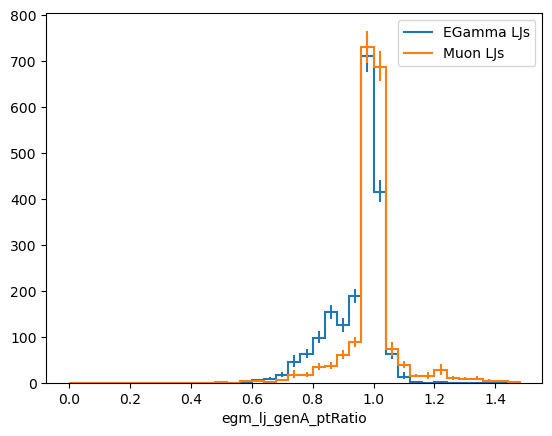

In [5]:
hists["egm_lj_genA_ptRatio"]["2mu2e_matchedLj", :1.5j].plot1d()
hists["mu_lj_genA_ptRatio"]["2mu2e_matchedLj", :1.5j].plot1d()
plt.legend(["EGamma LJs", "Muon LJs"])
plt.show()

Muon LJs do a little better job than EGamma and are a little more symmetric about 1.0, but both are pretty good.

Would be nice to see how this varies with bound state mass, dark photon decay length, and dsa- vs pf-muons. Plan to return to this later.